### Agricultural Stress Index (ASI)
Exploration of ASI for Malawi and its correlation with dry spells.  
Note that the ASI is not specifically callibrated for Malawi and thus might not result in the most accurate capturing of the actual agricultural stress

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import seaborn as sns

In [3]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_url

/Users/tinkavalentijn/Documents/CHD/AAFI/pa-anticipatory-action/


In [4]:
def plot_geo_var(df, sub_col, var_col, title=None, predef_bins=None, colp_num=2, cmap='YlOrRd',figsize=(16,9)):
    #plots one legend for all subplots. Version in eth notebook plots legend per subplot
    """
    Plot the values of "col" for the dates present in df_trig
    If giving predef_bins then the data will be colored according to the bins, else a different colour will be assigned to each unique value in the data for each date
    df: DataFrame containing all the data of all regions
    df_trig: DataFrame containing the dates for which plots should be shown (generally those dates that the trigger is met)
    col: string with column to plot
    shape_path: relative path to the admin1 shapefile
    title: string with title of whole figure (so not the subplots)
    predef_bins: list with bin values
    """

    num_plots = len(df[sub_col].unique())
    if num_plots==1:
        colp_num=1
    rows = math.ceil(num_plots / colp_num)

    position = range(1, num_plots + 1)
    fig, axs = plt.subplots(rows,colp_num,figsize=figsize, 
                        facecolor='w',
                        constrained_layout=True, 
                        sharex=True, sharey=True, 
                        subplot_kw=dict(aspect='equal'))

    axs = axs.ravel()

    if predef_bins is not None:
        scheme = None
        norm2 = mcolors.BoundaryNorm(boundaries=predef_bins, ncolors=256)
        legend_kwds=None
    else:
        scheme = "natural_breaks"
        norm2 = None
        legend_kwds = {'bbox_to_anchor': (1.6, 1)}


    for i, c in enumerate(df[sub_col].unique()):
        df_sub = df[df[sub_col] == c]
        #if no predef bins, set unique color for each unique value
        if predef_bins is None:
            colors = len(df_sub[var_col].dropna().unique())
        #else colors will be determined by norm and cmap
        else:
            colors = None

        if df_sub[var_col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_sub[var_col].isnull().values.any():
            df_sub.plot(var_col, ax=axs[i], cmap=cmap, k=colors, norm=norm2, legend=False, scheme=scheme,
                        missing_kwds={"color": "lightgrey", "edgecolor": "red",
                                      "hatch": "///",
                                      "label": "Missing values"})
        else:
            df_sub.plot(var_col, ax=axs[i], cmap=cmap, k=colors, norm=norm2, legend=False, scheme=scheme)
        df.boundary.plot(linewidth=0.2, ax=axs[i])

        axs[i].axis("off")
        axs[i].set_title(c)
    patch_col = axs[0].collections[0]
    cb = fig.colorbar(patch_col, ax=axs, shrink=0.5)

        
    if title:
        fig.suptitle(title, fontsize=14, y=0.92)

    return fig

In [5]:
def get_new_name(name, n_dict):
    """
    Return the values of a dict if name is in the keys of the dict
    Args:
        name: string of interest
        n_dict: dict with possibly "name" as key

    Returns:

    """
    if name in n_dict.keys():
        return n_dict[name]
    else:
        return name

#### Set config values

In [6]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_folder = os.path.join(config.DATA_DIR, "raw", country)
country_folder_exploration = os.path.join(config.DATA_DIR, "exploration", country)

In [7]:
adm1_bound_path=os.path.join(country_folder,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_folder,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [8]:
#annual summary
asi_url_annual=f"http://www.fao.org/giews/earthobservation/asis/data/country/{parameters['iso3_code']}/MAP_ASI/DATA/ASI_AnnualSummary_Season1_data.csv"
##dekad summary
asi_url_dekad=f"http://www.fao.org/giews/earthobservation/asis/data/country/{parameters['iso3_code']}/MAP_ASI/DATA/ASI_Dekad_Season1_data.csv"

In [9]:
# #only needed if not downloaded yet
# download_url(asi_url_annual,os.path.join(country_folder_exploration,"ASI",f"{country}_asi_annual.csv"))
# download_url(asi_url_dekad,os.path.join(country_folder_exploration,"ASI",f"{country}_asi_dekad.csv"))

### Per year
For dry spells we probably need to use the dekad data, but to get an idea of the values
ASI is only reported at ADM1 so need to see how we map that with the ADM2 dry spell data

In [10]:
df=pd.read_csv(os.path.join(country_folder_exploration,"ASI",f"{country}_asi_annual.csv"))
df.columns = map(str.lower, df.columns)

In [11]:
df

,crop_mask,country,adm1_code,province,year,data,unit
0,Cropland,Malawi,NaN,ALL,2019,5.238,VHI % below 35
1,Cropland,Malawi,NaN,ALL,2018,4.480,VHI % below 35
2,Cropland,Malawi,NaN,ALL,2017,1.301,VHI % below 35
3,Cropland,Malawi,NaN,ALL,2016,18.457,VHI % below 35
4,Cropland,Malawi,NaN,ALL,2015,6.350,VHI % below 35
...,...,...,...,...,...,...,...
175,Cropland,Malawi,65268.0,Area under National Administration,1985,0.000,VHI % below 35
176,Cropland,Malawi,1888.0,Central Region,1984,0.000,VHI % below 35
177,Cropland,Malawi,1889.0,Northern Region,1984,0.122,VHI % below 35
178,Cropland,Malawi,1890.0,Southern Region,1984,0.000,VHI % below 35


In [12]:
df[df.year==2019]

,crop_mask,country,adm1_code,province,year,data,unit
0,Cropland,Malawi,NaN,ALL,2019,5.238,VHI % below 35
36,Cropland,Malawi,1888.0,Central Region,2019,3.808,VHI % below 35
37,Cropland,Malawi,1889.0,Northern Region,2019,15.722,VHI % below 35
38,Cropland,Malawi,1890.0,Southern Region,2019,0.891,VHI % below 35
39,Cropland,Malawi,65268.0,Area under National Administration,2019,74.490,VHI % below 35


In [13]:
df_bound = gpd.read_file(adm1_bound_path)

In [14]:
df.province.unique()

array(['ALL', 'Central Region', 'Northern Region', 'Southern Region',
       'Area under National Administration'], dtype=object)

In [15]:
df_bound.ADM1_EN.unique()

array(['Central', 'Northern', 'Southern'], dtype=object)

In [16]:
#map ASI adm1 names to shapefile adm1 names
province_mapping={"Central Region":"Central","Northern Region":"Northern","Southern Region":"Southern"}

In [17]:
df["province"]=df["province"].apply(
            lambda x: get_new_name(x, province_mapping))

In [18]:
dfg=df_bound[["ADM1_EN","geometry"]].merge(df,left_on="ADM1_EN",right_on="province")

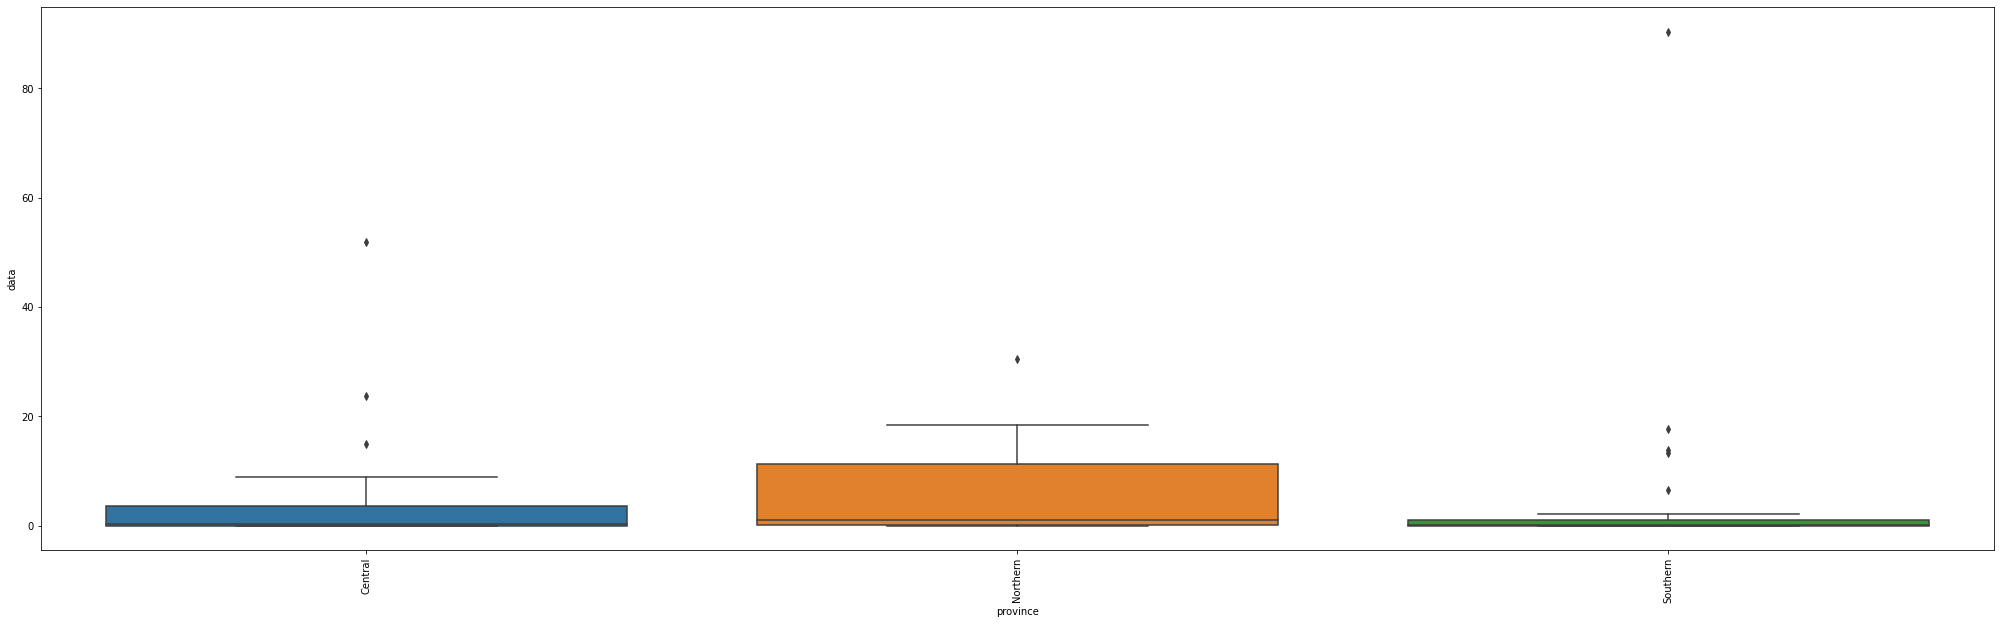

In [19]:
#distribution of values across the adm1 regions
fig, ax = plt.subplots(1, 1,figsize=(35,10))
g=sns.boxplot(x="province", y="data",data=dfg, ax=ax)
plt.xticks(rotation=90);

In [ ]:
fig=plot_geo_var(dfg.sort_values("year"),"year","data",predef_bins=np.arange(0,100,10),colp_num=9,figsize=(20,20))

### Per dekad
Now only selecting the third dekad, but have to figure a way how we want to connect it with dry spells. Possibly looking at the ASI at the end of a dry spell? Or ASI at the end of a dekad and how many adm2's within an adm1 were experiencing a dry spell during that time?

In [ ]:
dfd=pd.read_csv(os.path.join(country_folder_exploration,"ASI",f"{country}_asi_dekad.csv"))
dfd.columns = map(str.lower, dfd.columns)
dfd["date"]=pd.to_datetime(dfd.date)

In [ ]:
dfd[(dfd.year==2019)&(dfd.dekad==3)].head()

In [ ]:
#map ASI adm1 names to shapefile adm1 names
province_mapping={"Central Region":"Central","Northern Region":"Northern","Southern Region":"Southern"}
dfd["province"]=dfd["province"].apply(
            lambda x: get_new_name(x, province_mapping))

In [ ]:
dfdg=df_bound[["ADM1_EN","geometry"]].merge(dfd,left_on="ADM1_EN",right_on="province")

In [ ]:
#distribution of values across the adm1 regions
fig, ax = plt.subplots(1, 1,figsize=(35,10))
g=sns.boxplot(x="province", y="data",data=dfdg, ax=ax)
plt.xticks(rotation=90);